In [3]:
from DELPHI import *
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
from scipy.constants import pi
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *

\begin{equation}
g(\tau) = e^{-b\tau^2}\sum_{k=0}^{n_0}g_kL_k^0(a\tau^2)
\end{equation}
For a purely Gaussian beam $b = \frac{1}{2\sigma_z^2}$, $a=b$, $g_0=\frac{b}{\pi}$, $g_{k\neq 0 } = 0$, $A = 4\sigma_z$

For a Gaussian bunch , and assuming only the first expansion term where $L_0^0(a\tau^2) = 1$
$$g(\tau) = \frac{1}{\sqrt{2\pi}\sigma_z}\exp{\left(-\frac{\tau^2}{2\sigma_z^2}\right)}$$

(500000, 2)


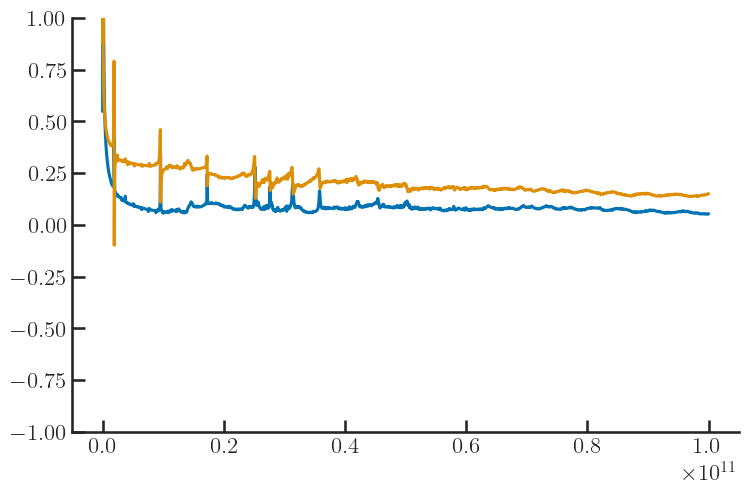

In [64]:
import pandas as pd
f = pd.read_csv('Zydip.dat', sep='\t', header=None)
Z_freqs = f[0][f[0]>0]
Zre = f[1][f[0]>0]
Zim = f[2][f[0]>0]
plt.ylim(-1, 1)
Z = np.vstack((Zre, Zim)).T
# Z = Z.reshape(Z.shape[1], Z.shape[0])
plt.plot(Z_freqs, Z[:,0]/1e6,)
plt.plot(Z_freqs, Z[:,1]/1e6,)
print(Z.shape)

/home/gubaidulin/Codes/TrackingCodes/mbtrack2/mbtrack2/impedance/resistive_wall.py:222: RuntimeWarning: divide by zero encountered in true_divide
  wl = - 1 * ( 1 / (4*np.pi * self.radius) *
/home/gubaidulin/Codes/TrackingCodes/mbtrack2/mbtrack2/impedance/resistive_wall.py:228: RuntimeWarning: divide by zero encountered in true_divide
  wt = (1 / (np.pi * self.radius**3) *


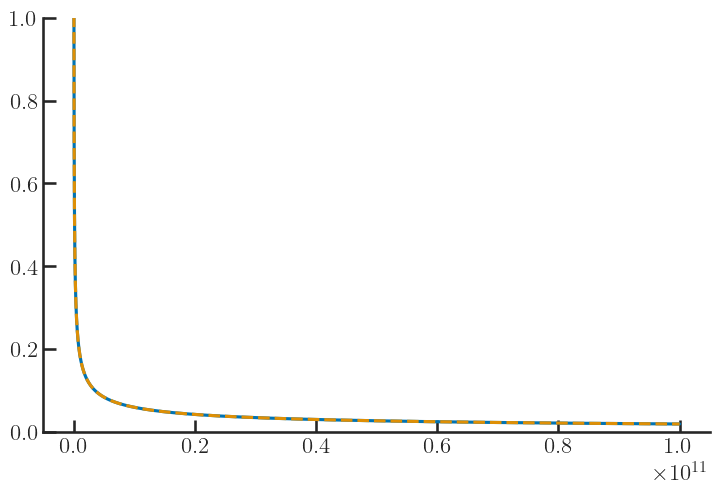

In [65]:
from mbtrack2.impedance import CircularResistiveWall
from scipy.constants import c
res_wall = CircularResistiveWall(time=np.linspace(0, 0.5/c),
                     frequency=Z_freqs,
                     length=350.749,
                     rho=2.135e-8,
                     radius=6.4e-3,
                     exact=False,
                     atol=1e-20)
Zre = res_wall.Zydip.data['real']
Zim = res_wall.Zydip.data['imag']
plt.plot(Z_freqs, Zre/1e6)
plt.plot(Z_freqs, Zim/1e6, linestyle='dashed')
plt.ylim(0, 1)
Zres = np.vstack((Zre, Zim)).T

In [4]:
from machine_data.soleil import v2366
ring = v2366(IDs='open', load_lattice=False)
print(ring.tune)
ring.ac

[54.2 18.3]


0.00010695

In [68]:
# it's better to use this fitting function, otherwise the growthrates are not correct
taub = 4*ring.sigma_0
print('rms bunch length {:.1e}'.format(ring.sigma_0))
g0, a, b = longdistribution_decomp(taub, typelong='Gaussian')
print(g0, a, b)

rms bunch length 9.0e-12
[1.96487584e+21] 8.0 8.0


In [69]:
Qp = np.linspace(0., 5., 11)
print(Qp)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [70]:
%%time
from tqdm.notebook import tqdm
Ib = 1.2e-3
print('Intensity per bunch {:.1e}'.format(INTENSITY_PER_BUNCH))
print('Lorenz gamma {:.1e}'.format(GAMMA))
# print('Coefficients for damper and impedance', coefdamper, coefZ)

eigvals_list = []
eigvec_list = []
# Qp = np.linspace(0., 5., 11)
Qp = 0
Ib = np.linspace(.1e-3, 5e-3, 25)
# Ib = 1.2e-3
for bunch_current in tqdm(Ib):
# for Qp in tqdm(Qp):
        I = bunch_current
        # I = Ib
        Nb = I/ring.f0/e
        omega_ksi = Qp/ring.ac*ring.omega0
        kmax=3
        coefdamper, coefZ = computes_coef(f0=ring.f0,
                                          dmax=0,
                                          b=b,
                                          g0=g0,
                                          dnormfactor=np.infty,
                                          taub=taub,
                                          dphase=0,
                                          M=1,
                                          Nb=Nb,
                                          gamma=ring.gamma,
                                          Q=ring.tune[1],
                                          particle='electron')
        eigvals, eigvecs, lmaxold, nmaxold, max_freq_old, matdamperold, matZold = eigenmodesDELPHI_converged(
                                                                                                       nx=0,
                                                                                                       M=1,
                                                                                                       omegaksi=omega_ksi,
                                                                                                       omega0=ring.omega0,
                                                                                                       tunefrac=(ring.tune[1]-np.floor(ring.tune[1])),
                                                                                                       a=a,
                                                                                                       b=b,
                                                                                                       taub=taub,
                                                                                                       g=g0,
                                                                                                       Z=Z,
                                                                                                       kmax=kmax,
                                                                                                       freqZ=Z_freqs,
                                                                                                       coefdamper=coefdamper,
                                                                                                       coefZ=coefZ,
                                                                                                       omegas=Q_S*ring.omega0,
                                                                                                       flageigenvect=True,
                                                                                                       optimized_convergence=True,
                                                                                                       lmaxold=-1,
                                                                                                       nmaxold=-1,
                                                                                                       crit=5e-2,
                                                                                                       abseps=1e-3
        )
        eigvals_list.append(eigvals/OMEGA_REV)
        eigvec_list.append(eigvecs)

Intensity per bunch 8.9e+09
Lorenz gamma 5.4e+03


  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 43min 52s, sys: 1h 4min 50s, total: 1h 48min 42s
Wall time: 16min 27s


The dipole moment of the bunch is given by $$\rho_l (r) = (r/A)^{|l|}e^{-br^2}\sum_{n=0}^{\infty}c_{ln}L_n^{|l|}(ar^2)$$,
where $L_n$ is the Laguerre polynomial, $c_{ln}$ should be DELPHI output eigenvectors. (This is from Nicolas' article in Zermatt proceedings)

(13, 9, 117)
(117,)
(-0.006289276831237574+0.0001786172820097114j)


(-3.0, 3.0)

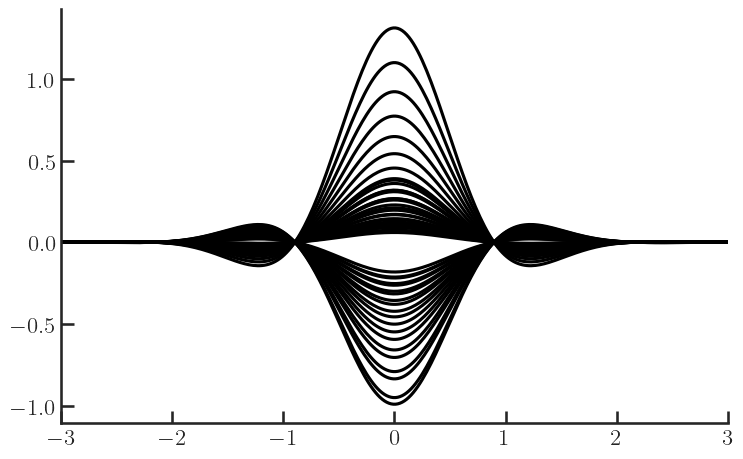

In [330]:
%matplotlib inline
from numpy import count_nonzero
from scipy.special import genlaguerre
# print(matdamperold)
# print(count_nonzero(matdamperold))
# print(count_nonzero(matZold),)
print(eigvecs.shape)
print(eigvals.shape)
# plt.plot(eigvecs[0,:,0])
sigma_z = 9e-12
def get_line_density(r, c_n, l, a, b):
    A = 4*sigma_z
    n = c_n.shape[0]
    L_n = np.empty(shape=(n,r.shape[0]))
    for i in range(n):
        L_n[i,:] = np.vectorize(genlaguerre(i, np.abs(l)))(a*r**2)
    return np.power(r/A, np.abs(l))*np.exp(-b*r**2)*np.dot(c_n, L_n)

r = sigma_z*np.linspace(-10, 10, 1000)
c_ln = eigvecs[:,:,0]
print(eigvals[-1]/OMEGA_REV)
l = 0
def density_profile(r, sigma_z):
    return np.exp(-.5*(r/sigma_z)**2)
m = 0
for t in range(0, 10000, 200):
    plt.plot(r/sigma_z, np.exp(-1j*eigvals[m]/OMEGA_REV*t)*density_profile(r, sigma_z)*get_line_density(r, np.real(eigvecs[:,l,m]), l, .5/sigma_z**2, .5/sigma_z**2), color='black')
    # plt.plot(r/sigma_z, np.exp(-1j*eigvals[-1]/OMEGA_REV*t)*density_profile(r, sigma_z)*get_line_density(r, np.imag(eigvecs[:,l,m]), l, .5/sigma_z**2, .5/sigma_z**2))

plt.xlim(-3, 3)
# matZnew[matZold < 1e-16] = 0
# sparsity_imp = 1.0 - ( count_nonzero(matZnew) / float(matZnew.size) )
# sparsity_damper = 1.0 - ( count_nonzero(matdamperold) / float(matdamperold.size) )
# print('Sparsity of impedance matrix {:.2f}'.format(sparsity_imp))
# print('Sparsity of damper matrix {:.2f}'.format(sparsity_damper))

(117,)
174.1835367824175
6 8
(13, 9, 13, 9)


(-5.0, 5.0)

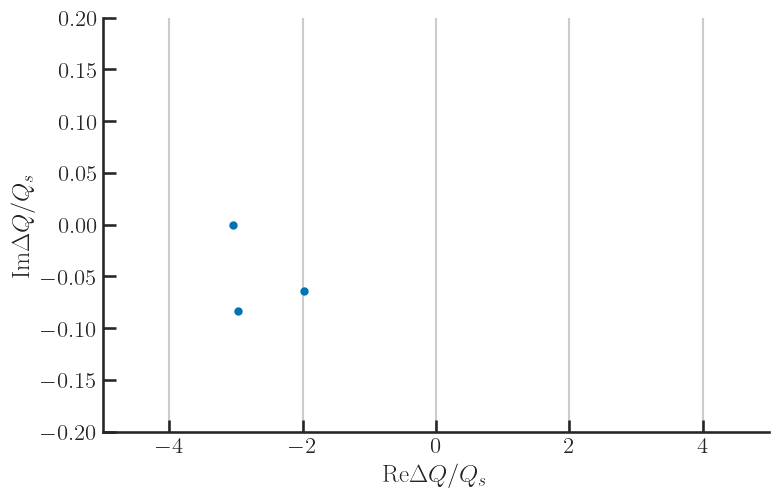

In [71]:
%matplotlib inline
print(eigvals.shape)
print(max_freq_old/1e9)
print(lmaxold, nmaxold)
print(matZold.shape)
fig, ax = plt.subplots(1, 1)
ax.scatter(np.real(eigvals[:kmax])/Q_S/OMEGA_REV, np.imag(eigvals[:kmax])/Q_S/OMEGA_REV, marker='.')
ax.set_xlabel('$\mathrm{Re}\Delta Q/Q_s$')
ax.set_ylabel('$\mathrm{Im}\Delta Q/Q_s$')
ax.xaxis.grid(True)
ax.set_ylim(-.2, .2)
ax.set_xlim(-5, 5)

### TMCI plot

In [ ]:
%matplotlib inline
# Ib = np.linspace(1.2e-3, 2e-3, 8)
new_list = []
fig, ax = plt.subplots(1, 1)
for i, I in enumerate(Ib):
    for j in range(0, len(eigvals_list[i])):        
        # ax.scatter(I/1e-3, np.real(eigvals_list[i])[j]/Q_S, color='b', label='real part', marker='.')
        ax.scatter(I*1e3, np.imag(eigvals_list[i])[j]/Q_S, color='r', label='imag part', marker='.')    
ax.set_xlabel('Bunch current, $I_b$ (mA)')
ax.set_ylabel('Coherent tune shift, $\Delta Q_\mathrm{coh}/Q_s$')
ax.set_xlim()
# ax.set_ylim(-2, 1.)
# ax.set_ylim(-2, 2)


### Chromaticity plot

In [50]:
%matplotlib qt
new_list = []
fig, ax = plt.subplots(1, 1)
Qp = np.linspace(0.1, 5., 11)
for i, Qp in enumerate(Qp):
    for j in range(0, len(eigvals_list[i])):    
        ax.scatter(Qp, np.real(eigvals_list[i])[j]/Q_S, color='b', label='real part', marker='.')
        # ax.scatter(Qp, -np.imag(eigvals_list[i])[j]/Q_S, color='r', label='imag part', marker='.')    
        # ax.scatter(Qp, np.imag(eigvals_list[i])[j]/(2*pi), color='black', label='imag part', marker='.')    
        
ax.set_xlabel('Chromaticity, $Q\'$')
ax.set_ylabel('Coherent tune shift, $\Delta Q_\mathrm{coh}/Q_s$')
# ax.set_ylabel('Growth rate, $\\tau^{-1}$ (turns$^{-1}$)')
# ax.set_ylim(0, )
print(Q_S)

0.0019479947512890817


In [ ]:
%%time
import time
def resonator_impedance(R, fr, Q, freq):
    '''
    Resonator model impedance (transverse)
    R=shunt impedance (Ohm/m), fr=resonant frequency, Q=quality factor
    computes impedance at the frequencies freq (2 columns array)
    '''
    Z = np.zeros((len(freq), 2))
    Zt = (R*fr/freq)/(1.-1j*Q*(fr/freq-freq/fr))
    Z[:, 0] = np.real(Zt)
    Z[:, 1] = np.imag(Zt)
    return Z

machine = 'LHC'

# parameter definitions
plane = 'x'
dphase = 0.
M = 1
Nbscan = [3.8e11] #, 4.9e11, 5e11]
# Nbscan = np.arange(1.e10,8.1e11,1e10)
dampscan = [0.]

nxscan = np.arange(M)
Qx = 62.3099997613612
Qp = 0
# expected tuneshifts from 2019 LHC BB TMCI calculations by N. Mounet on local machine
# (maybe using a slightly older version of DELPHI)
# (notebook ~/cernbox/Notebooks/TMCI_broadband_as_Elias_GALACTIC.ipynb,
# results in /afs/cern.ch/work/n/nimounet/private/DELPHI_results/LHC_BB/TMCI/TMCI_with_BB_25MOhm_0p8GHz/DELPHIrun)
# NOTE: these calculations were done with flag_trapz=1 so are slightly different
expected_dQs = {3.8e11:  [(-1.5085252397e-03 - 1.1486943153e-04*1j),
                          ],
                }
flagnorm = 0
mu0 = 4e-7*np.pi
Z0 = mu0*clight
eps0 = 1./(mu0*clight**2)

# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
# machine and beam parameters
gamma = 6927.62806135325
beta = np.sqrt(1.-1./(gamma**2))
omega0 = 70657.55656577148

# Broad-band impedance
Rt = 25e6  # shunt impedance in MOhm/m
fr = 0.8e9  # cutoff frequency in Hz
Q = 1  # quality factor
freq = np.sort(
    list(set(np.hstack((np.logspace(1, 13, 121), np.linspace(5e8, 5e9, 201))))))
Z = resonator_impedance(Rt, fr, Q, freq)

# longitudinal parameters
taub = 1e-9  # bunch length (sec)
typelong = 'Gaussian'  # Longitudinal distribution
eta = 0.0003479538899641484  # slip factor
omegas = 134.87527592319398

t0 = time.time()
# Longitudinal distribution decomposition
g, a, b = longdistribution_decomp(taub, typelong=typelong)
print("g[0]={}, a={}, b={}".format(g[0],a,b))

In [ ]:
damp = 0
dnormfactor=np.infty
dphase=0
f0 = omega0/2/np.pi
Nb=Nbscan[0]
particle='proton'
print('proton beam intensity {:.1e}'.format(Nb))
coefdamper, coefZ = computes_coef(
                                f0,
                                damp,
                                b,
                                g[0],
                                dnormfactor,
                                taub,
                                dphase,
                                M,
                                Nb,
                                gamma,
                                Q,
                                particle=particle)
print(coefdamper)
print('Impedance matrix coefficient: {:.1e}+j{:.1e}'.format(np.real(coefZ), np.imag(coefZ)))

In [ ]:
if True:
    # DELPHI launch
    result_dict = eigenmodesDELPHI_converged_scan(
        [Qp],
        nxscan,
        dampscan,
        Nbscan,
        [omegas],
        [dphase],
        M,
        omega0,
        Qx,
        gamma,
        eta,
        a,
        b,
        taub,
        g,
        Z,
        freq,
        particle='proton',
        flagnorm=flagnorm,
        flag_trapz=1,
        flagdamperimp=0,
        d=None,
        freqd=None,
        kmax=3,
        kmaxplot=3,
        crit=crit,
        abseps=abseps,
        flagm0=True,
        flageigenvect=False,
        optimized_convergence=True,
        # fixed_lmax_nmax=(4, 4)
    )
    # tuneshift_most = result_dict['tuneshift_most']
    # tuneshiftnx = result_dict['tuneshiftnx']

#     np.testing.assert_array_equal(tuneshift_most.shape, (1, 1, 1, 1, 1, 1),
#                                   err_msg="tuneshift_most has incorrect shape")
#     np.testing.assert_array_equal(tuneshiftnx.shape, (1, 1, 1, 1, 1, 1, 1),
#                                   err_msg="tuneshiftnx has incorrect shape")

#     assert not np.any(np.isnan(tuneshift_most)), "{} nan found".format(
#         len(np.any(np.isnan(tuneshiftnx))))
#     assert not np.all(tuneshift_most == 0.), "only zeros found"

# #     np.testing.assert_allclose(np.real(tuneshiftnx.squeeze()), np.real(tuneshift_most.squeeze()),
# #                                rtol=0., atol=1e-15, err_msg="tuneshift_most and tuneshiftnx differ (real part)")
# #     np.testing.assert_allclose(np.imag(tuneshiftnx.squeeze()), np.imag(tuneshift_most.squeeze()),
# #                                rtol=0., atol=1e-15, err_msg="tuneshift_most and tuneshiftnx differ (imag part)")

#     for iNb, Nb in enumerate(Nbscan):
#         if Nb in expected_dQs:
#             expected_dQ = expected_dQs[Nb]
            # print(tuneshift_most[:,:,iNb,:,:,:].squeeze())
            # # print(expected_dQ)
            # np.testing.assert_allclose(np.real(tuneshift_most[:, :, iNb, :, :, :].squeeze()), np.real(expected_dQ),
            #                            rtol=1e-3, atol=0.,
            #                            err_msg="Nb={}: real(tuneshift_most) not as expected, diff.={}".format(
            #                            Nb, np.real(tuneshift_most[:, :, iNb, :, :, :].squeeze())-np.real(expected_dQ)))
            # np.testing.assert_allclose(np.imag(tuneshift_most[:, :, iNb, :, :, :].squeeze()), np.imag(expected_dQ),
            #                            rtol=1e-2, atol=0,
            #                            err_msg="Nb={}: imag(tuneshift_most) not as expected, diff.={}".format(
            #                            Nb, np.imag(tuneshift_most[:, :, iNb, :, :, :].squeeze())-np.imag(expected_dQ)))

In [14]:
import pandas as pd

In [21]:
datafr = pd.read_csv('delphi(sigma_z=1.5e-11,plane=vertical,Qp=0.0).csv', sep='\t')

In [24]:
%matplotlib qt
from matplotlib.colors import ListedColormap
# m = np.max(-datafr['eigvals_im'])
# print(-datafr['eigvals_im']/m)
# alph = -datafr['eigvals_im']/m
# alph[alph<0]=0
palette = sbs.color_palette('tab10', as_cmap=True)
color = np.round(np.abs(datafr['eigvals_re'][:]/Q_S))
fig, axs = plt.subplots(1, 2)

axs[0].scatter(datafr['BunchCurrent']/1e-3, datafr['eigvals_im']/Q_S, marker='.', c=color, cmap=palette)
axs[1].scatter(datafr['BunchCurrent']/1e-3, datafr['eigvals_re']/Q_S, marker='.', c=color, cmap=palette)

# axs[0].scatter(datafr['Qp'], -datafr['eigvals_im']/Q_S, marker='.', c=color, cmap=palette)
# axs[1].scatter(datafr['Qp'], datafr['eigvals_re']/Q_S, marker='.', c=color, cmap=palette)

for ax in axs:
    ax.set_xlabel('Bunch current, $I_b$ (mA)')
    # ax.set_xlabel('Chromaticity, $Q\'$')
    ax.set_ylabel('Coherent tune shift $\Delta Q_\mathrm{coh}/Q_s$')
axs[0].title.set_text('Imaginary part')
axs[0].title.set_text('Real part')
# axs[0].set_ylim(0, )
axs[1].set_ylim(-3, 3)

(-3.0, 3.0)